In [1]:
import json
# from yahoofinancials imp\`ort YahooFinancials as YF
import time
import datetime
import pandas as pd
# from pandas_datareader import data
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
from utils import *
# from pydantic import BaseModelttt
# from backtester import *
# from backtest import *
import matplotlib.pyplot as plt
# import quandl
import math

%matplotlib inline
# %matplotlib notebook

In [2]:
tickers = ['AAPL','T', 'MSFT']
stocks = getStocksData(tickers, 100, save_new=False)
stocks[tickers[0]].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-19,176.389999,176.389999,174.940002,175.160004,174.923798,55772400
1,2023-05-22,173.979996,174.710007,173.449997,174.199997,173.965073,43570900
2,2023-05-23,173.130005,173.380005,171.279999,171.559998,171.328644,50747300
3,2023-05-24,171.089996,172.419998,170.520004,171.839996,171.608261,45143500
4,2023-05-25,172.410004,173.899994,171.690002,172.990005,172.756714,56058300


In [3]:
df = stocks[tickers[0]]
df.index

RangeIndex(start=0, stop=63, step=1)

getting new data
For index: 1
previous position 0.0
price 16.350000381469727
previous cash 7500.0
strategy position 0.8799439333141695
cash needed: 14.387083645358643
Making trade: Cash = 7485.612916354641
For index: 2
previous position 0.8799439333141695
price 16.260000228881836
previous cash 7485.612916354641
strategy position 0.7448767363711842
cash needed: -2.196192653207369
Making trade: Cash = 7487.809109007849
For index: 3
previous position 0.7448767363711842
price 16.110000610351562
previous cash 7487.809109007849
strategy position 0.6875017545218174
cash needed: -0.9243109926122097
Making trade: Cash = 7488.733420000461
For index: 4
previous position 0.6875017545218174
price 15.670000076293945
previous cash 7488.733420000461
strategy position 0.3332504815635225
cash needed: -5.551117474283708
Making trade: Cash = 7494.284537474744
For index: 5
previous position 0.3332504815635225
price 15.229999542236328
previous cash 7494.284537474744
strategy position 0.5612128576945425
cash

,0,T_position,T_open,T_close,T_pos_diff,T_cash_needed,T_cash,T_holdings,total
0,0,0.00,16.59,16.31,0.00,NaN,7500.00,0.00,7500.00
1,1,0.88,16.35,16.38,0.88,14.39,7485.61,14.39,7500.00
2,2,0.74,16.26,16.10,-0.14,-2.20,7487.81,12.11,7499.92
3,3,0.69,16.11,15.95,-0.06,-0.92,7488.73,11.08,7499.81
4,4,0.33,15.67,15.15,-0.35,-5.55,7494.28,5.22,7499.51
5,5,0.56,15.23,15.50,0.23,3.47,7490.81,8.55,7499.36
6,6,0.66,15.49,15.64,0.10,1.57,7489.24,10.26,7499.51
7,7,0.73,15.66,15.73,0.07,1.02,7488.22,11.39,7499.62
8,8,0.78,15.75,15.81,0.05,0.82,7487.40,12.29,7499.68
9,9,0.51,15.08,15.21,-0.27,-4.11,7491.50,7.66,7499.16


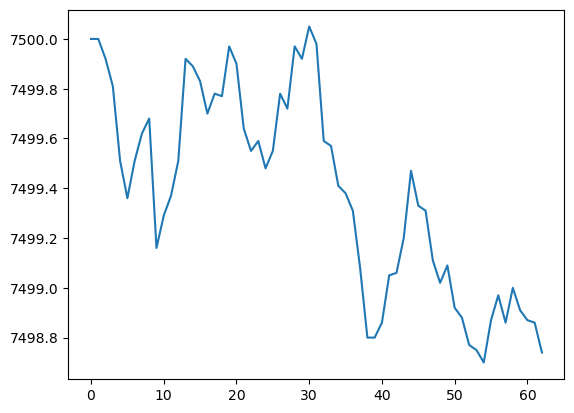

In [99]:
import pandas as pd
import math

class Stock:
    def __init__(self, ticker,df=None,initial_capital=1000, path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl", save_new = False,debug=False):
        self.ticker = ticker
        self.initial_capital = initial_capital
        self.isBankrupt = 0
        self.path = path
        self.savedBars = None
        self.positionOutCash = False
        self.strategies = []
        self.debug = debug
        with open(self.path, 'rb') as handle:
            self.savedBars = pickle.load(handle)
        self.df = df
        if (self.df == None or save_new):
            print('getting new data')
            self.df = self.getStocksData(ticker)
        
        self.bars = self.df
        self.positions = pd.DataFrame(self.df.index)
       
        # print("bars")
        # print(self.bars)

    def getSavedData(self, ticker):
        with open(self.path, 'rb') as handle:
            stocks = pickle.load(handle)
            if self.ticker in stocks:
                return stocks[self.ticker]
            else:
                return None



    # gets stock ticket data for current day going back days_back
    def getStocksData(self,tickers, start='2023-01-01', end='2023-09-01', save_new=False):
        def convert_time(epoch):
            return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

        epoch_time = int(time.time())
        day_epoch = 60*60*24
        # check if data exists, if not pull data
        if (save_new or self.ticker not in self.savedBars):
            print("in get stocks data")
            try:
                # download dataframe
                # data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
                if (self.debug):
                    print(f"Trying download of {self.ticker}")
                stock_data =  pdr.get_data_yahoo(self.ticker, start=start,end=end)
                stock_data = stock_data.reset_index()
                if (self.debug):
                    print(f"Downloaded bars of {self.ticker}")
                    print(stock_data)
                self.savedBars[self.ticker] = stock_data
                with open(self.path, 'wb') as handle:
                    pickle.dump(self.savedBars, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
                return stock_data
            except:
                print("Skipping stock for {}, bad data :<".format(self.ticker))
        else:
            return self.savedBars[self.ticker]




    def macd(self, short=12, long=26):
        df = self.df
        exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
        exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_norm'] = (df['macd'] - df['macd'].min()) / (df['macd'].max() - df['macd'].min())
        return df['macd_norm']
    
    def addStrategy(self, func):
        self.strategies.append(func)

    def viewStrategies(self):
        for x in self.strategies:
            print(x)

    def backtest(self):
        # macd1 = 500 * self.macd(self.df, 12, 23)
        # macd2 = self.macd(self.df, 12, 43)
        # macd3 = self.macd(self.df, 12, 53)
        # strat1 = pd.DataFrame(self.bars.index)

        # strat1 = pd.Series(500, index=self.bars.index)
        strategies = self.strategies

        self.positions[self.ticker + '_position'] = pd.concat(strategies).groupby(level=0).mean()
        self.positions[self.ticker + '_position'].at[0] = 0
        self.positions[self.ticker + '_open'] = self.bars.Open
        self.positions[self.ticker + '_close'] = self.bars.Close

        self.positions[self.ticker + '_pos_diff'] = self.positions[self.ticker + "_position"].diff()

        self.positions[self.ticker + "_cash_needed"] = self.positions[self.ticker + "_pos_diff"] * self.bars.Open
        self.positions[self.ticker + "_cash"] = self.initial_capital - self.positions[f'{self.ticker}_cash_needed'].cumsum()
        self.positions[self.ticker + "_holdings"] = 0
        self.positions[self.ticker + "_pos_diff"].at[0] = 0
        self.positions.at[0, f"{self.ticker}_cash"] = self.initial_capital


        cash_held = self.initial_capital
        available_cash = self.initial_capital

        for index, row in self.positions.iterrows():
            if index == 0:
                continue

            price = row[self.ticker + "_open"]
            cash = self.positions.loc[index - 1][self.ticker + "_cash"]
            holdings = self.positions.loc[index - 1][self.ticker + "_holdings"]
            position = self.positions.loc[index][self.ticker + '_position']
            pos_diff = self.positions.loc[index][self.ticker + '_position'] - self.positions.loc[index - 1][self.ticker + '_position']
            cash_needed = pos_diff * price
            if (self.debug):
                print(f"For index: {index}")
                print(f"previous position {self.positions.loc[index - 1][self.ticker + '_position']}")
                print(f"price {price}")
                print(f"previous cash {cash}")
                print(f"strategy position {position}")
                print(f"cash needed: {cash_needed}")


            if (cash > cash_needed) and (not self.positionOutCash):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"Making trade: Cash = {cash}")
                # holdings = holdings + cash_needed
               
            # is there enough cash
            elif (cash_needed < 0):
                cash = cash - cash_needed
                if (self.debug):
                    print(f"cash added from short {cash}")
                if (cash > (position * price)):
                    self.positionOutCash = False
                    if (self.debug):
                        print(f"position is back in range {index, (position *price)}")
            else:
                if (self.debug):
                    print("ran out of money")
                # ignore position and pos_diff
                # cap 
                # new_pos = cash / price
                # print(f"new pos {new_pos}")
                # if (np.isnan(new_pos)):
                #     new_pos = 0
              
                # self.positions.at[index, f"{self.ticker}_position"] = new_pos
                # self.positions.at[index, f"{self.ticker}_pos_diff"] = new_pos - self.positions.loc[index - 1][self.ticker + "_pos_diff"]
                # self.positions.at[index, f"{self.ticker}_pos_diff"] = self.positions.loc[index - 1][self.ticker + "_pos_diff"]
                if (index == 1):
                    self.positions.at[index, f"{self.ticker}_position"] = cash / price
                    if (self.debug):
                        print(f"setting first index position {cash} {price} {cash/price}")
                else:
                    self.positions.at[index, f"{self.ticker}_position"] = self.positions.at[index -1, f"{self.ticker}_position"]  
                    if (self.debug):
                        print("setting position to prev position")         
                # holdings = holdings + cash # spending all the cash

                self.positionOutCash = True
                cash = 0
                if (self.debug):
                    print(f"postion {self.positions.at[index, f'{self.ticker}_position']}")

            # self.positions.at[index, f"{self.ticker}_holdings"] = holdings

            self.positions.at[index, f"{self.ticker}_cash"] = cash

        self.positions[f'{self.ticker}_holdings'] = self.positions[f"{self.ticker}_position"] * self.positions[f"{self.ticker}_open"]
        self.positions['total'] = self.positions[f"{self.ticker}_cash"] + self.positions[f"{self.ticker}_holdings"]

        self.positions = self.positions.round(2)

        self.positions.total.plot()
        return self.positions
        # self.positions.total.gcf()

# Example usage
# df = ...  # Load your DataFrame here
initial_capital = 7500
ticker = 'T'

stock_instance = Stock(ticker,df=None,initial_capital = initial_capital, save_new=True,debug=True)
# stock_instance.addStrategy(500*stock_instance.macd())
# stock_instance.addStrategy(pd.Series(500, index=stock_instance.bars.index))
stock_instance.addStrategy(stock_instance.macd(1,15))
stock_instance.backtest()
# stock_instance.viewStrategies()
# stock_instance.strategies


In [49]:
stock_instance = Stock(ticker,df=None,initial_capital = initial_capital, debug=True)

,0,VZ_position,VZ_open,VZ_close,VZ_pos_diff,VZ_cash_needed,VZ_cash,VZ_holdings,total
0,0,0.00,36.22,36.05,0.00,NaN,7500.00,0.00,7500.00
1,1,197.48,36.25,35.96,197.48,7158.77,341.23,7158.77,7500.00
2,2,199.61,35.94,36.24,2.12,76.31,264.92,7173.86,7438.78
3,3,197.52,36.23,35.87,-2.09,-75.57,340.49,7156.18,7496.67
4,4,185.37,35.54,34.82,-12.16,-432.01,772.50,6587.88,7360.38
5,5,177.91,34.84,35.00,-7.45,-259.72,1032.22,6198.40,7230.62
6,6,171.38,34.97,34.90,-6.53,-228.20,1260.43,5993.32,7253.75
7,7,174.00,34.86,35.63,2.62,91.23,1169.20,6065.70,7234.90
8,8,177.25,35.60,35.72,3.25,115.57,1053.63,6310.02,7363.66
9,9,168.58,34.40,34.58,-8.66,-298.05,1351.68,5799.28,7150.96


In [92]:
ticker = 'T'

# stock_data =  pdr.get_data_yahoo(ticker, period="3mo")
stock_data =  pdr.get_data_yahoo(ticker, start='2023-04-01', end='2023-09-01')
stock_data = stock_data.reset_index()
stock_data

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-04-03,19.270000,19.480000,19.200001,19.389999,18.783941,31102500
1,2023-04-04,19.520000,19.650000,19.389999,19.639999,19.026127,34207600
2,2023-04-05,19.620001,19.930000,19.590000,19.879999,19.258625,38673200
3,2023-04-06,19.650000,19.790001,19.510000,19.650000,19.305784,29722600
4,2023-04-10,19.469999,19.600000,19.420000,19.570000,19.227186,23617500
5,2023-04-11,19.590000,19.910000,19.580000,19.690001,19.345085,24664800
6,2023-04-12,19.790001,19.879999,19.650000,19.770000,19.423683,28179500
7,2023-04-13,19.850000,19.980000,19.660000,19.959999,19.610353,25253900
8,2023-04-14,19.950001,19.990000,19.770000,19.930000,19.580879,24948400
9,2023-04-17,19.900000,19.920000,19.650000,19.790001,19.443333,23443900


In [94]:
epoch_time = int(time.time())
def convert_time(epoch):
    return time.strftime('%Y-%m-%d', time.localtime(epoch))
convert_time(epoch_time)

'2023-09-11'

In [7]:
days_back=10
save_new=False
path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"
with open(path, 'rb') as handle:
    stocks = pickle.load(handle)

stocks

{'AAPL':          Date        Open        High         Low       Close   Adj Close  \
 0  2023-05-19  176.389999  176.389999  174.940002  175.160004  174.923798   
 1  2023-05-22  173.979996  174.710007  173.449997  174.199997  173.965073   
 2  2023-05-23  173.130005  173.380005  171.279999  171.559998  171.328644   
 3  2023-05-24  171.089996  172.419998  170.520004  171.839996  171.608261   
 4  2023-05-25  172.410004  173.899994  171.690002  172.990005  172.756714   
 ..        ...         ...         ...         ...         ...         ...   
 58 2023-08-14  177.970001  179.690002  177.309998  179.460007  179.460007   
 59 2023-08-15  178.880005  179.479996  177.050003  177.449997  177.449997   
 60 2023-08-16  177.130005  178.539993  176.500000  176.570007  176.570007   
 61 2023-08-17  177.139999  177.509995  173.479996  174.000000  174.000000   
 62 2023-08-18  172.300003  175.100006  171.960007  174.490005  174.490005   
 
       Volume  
 0   55772400  
 1   43570900  
 2   5